In [1]:
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from generate_network import generate_network
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
def calc_servable_fraction(load, r, additional_nodes=0):
    """abc
    Parameters
    ----------
    load:float
        Percentage of vessels on the network compared to the 2021 total.

    r:int
        Range of a vessel.

    additional_nodes: int
        Number of additional nodes that should be inserted into the original network.
    """
    G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
    df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
    df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
    path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
    paths = pickle.load(open('data/final_paths.p', "rb"))

    # if additional nodes need to be considered, update G, paths and inserted accordingly
    inserted = []
    if additional_nodes != 0:
        G, paths, inserted = generate_network(G, paths, additional_nodes)

    # generate random data
    df_random = random_vessel_generator(df_ivs, load)
    flows = flow_computation(df_random)
    

    # execute first stage, with or without additional nodes
    df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(r, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h,
                                            additional_nodes=inserted)
    # determine total flow on network
    total_flow = sum(flows.values())

    # determine maximal supportable flow only limited by range
    max_supported = {i:flows[i] for i in flows if len(feasible_combinations[i])>0}
    max_supported = sum(max_supported.values())

    # calculate this as a fraction of the total flow
    serveable_fraction = (max_supported/total_flow)

    add_nodes_route = {}
    needed_nodes = {}
    for route, combis in feasible_combinations.items():
        additional_nodes_necessary = True
        for combi in combis:
            if all (len(str(i))>4 for i in combi):
                additional_nodes_necessary = False
                break

        add_nodes_route[route] = additional_nodes_necessary
        if additional_nodes_necessary:
            for combi in combis:
                needed_nodes[route] = []
                for node in combi:
                    sub_l=[]
                    if len(node)<4:
                        sub_l.append(node)
                        needed_nodes[route] += sub_l

    extra_nodes_used = list(needed_nodes.values())
    extra_nodes_used = [x for xs in extra_nodes_used for x in xs]
    extra_nodes_used = list(set(extra_nodes_used))
    extra_nodes_used = len(extra_nodes_used)

    return additional_nodes, extra_nodes_used, serveable_fraction

In [4]:
%%time
additional_nodes, extra_nodes_used, serveable_fraction = calc_servable_fraction(1, 150000, 20)

CPU times: total: 5.28 s
Wall time: 5.41 s


In [ ]:
%%time
plot_dict = {'r':[], 'additional_nodes':[], 'add_nodes_in_routes':[], 'servable_fraction':[]}
for r in np.arange(20000, 100000, 10000):
    for add_nodes in np.arange(0, 101, 10):
        additional_nodes, extra_nodes_used, serveable_fraction = calc_servable_fraction(1, r, 100, 5, 5, add_nodes)
        plot_dict['r'].append(r)
        plot_dict['additional_nodes'].append(add_nodes)
        plot_dict['add_nodes_in_routes'].append(extra_nodes_used)
        plot_dict['servable_fraction'].append(serveable_fraction)
        print(r, add_nodes)


In [ ]:
plot_dict1 = pickle.load(open('data/plot_dict_0_100_till150.p', 'rb'))
plot_dict2 = pickle.load(open('data/plot_dict_0_70_175-250.p', 'rb'))

In [12]:
plot_dict1 = pd.DataFrame.from_dict(plot_dict1)
plot_dict2 = pd.DataFrame.from_dict(plot_dict2)

In [17]:
plot_dict = pd.concat([plot_dict1, plot_dict2])

In [19]:
plot_dict

,r,additional_nodes,add_nodes_in_routes,servable_fraction
0,25000,0,0,0.109797
1,25000,10,0,0.104996
2,25000,20,0,0.110104
3,25000,30,2,0.118718
4,25000,40,5,0.134321
...,...,...,...,...
27,250000,30,5,0.999272
28,250000,40,4,0.999382
29,250000,50,5,0.999319
30,250000,60,5,0.999478


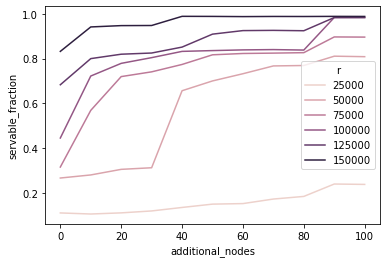

In [22]:
sns.lineplot(x='additional_nodes', y='servable_fraction', hue='r', data=plot_dict1)
plt.show()

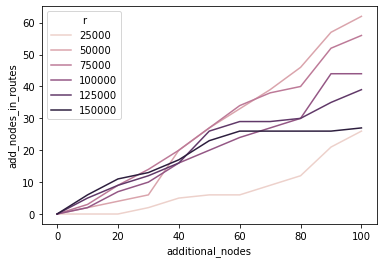

In [25]:
sns.lineplot(x='additional_nodes', y='add_nodes_in_routes', hue='r', data=plot_dict1)
plt.show()

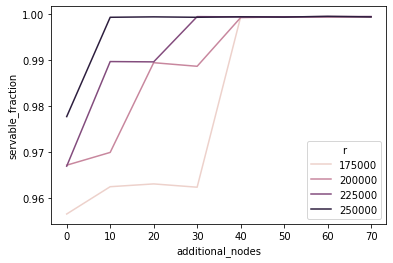

In [26]:
sns.lineplot(x='additional_nodes', y='servable_fraction', hue='r', data=plot_dict1)
plt.show()

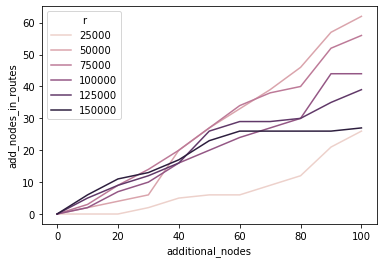

In [27]:
sns.lineplot(x='additional_nodes', y='add_nodes_in_routes', hue='r', data=plot_dict1)
plt.show()